# Cyber-resilience active inference model 1.0.0

### IMPORTS

In [2]:
import os
import sys
import pathlib
import copy
import time

import numpy as np
import itertools
import tqdm
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from random import sample, randint
from tqdm import tqdm
from multiprocessing import Pool

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min


path = pathlib.Path(os.getcwd())
module_path = str(path.parent) + '/'
sys.path.append(module_path)

try:
    import pymdp.core.control as control
    from pymdp.core import utils
except:
    import pymdp.control as control
    from pymdp import utils
    

from scipy.special import softmax, kl_div
from scipy.stats import entropy

import sklearn
from sklearn.decomposition import PCA

## 1. BUILD GRAPH

In [2]:
# G = nx.DiGraph()
# G.removed_edges = [] # Special property for keeping track of removed tracks

# # Two 'subway lines'
# route1 = [1, 2, 3]
# route2 = [1, 3]

# # Add nodes (representing stations)
# for node in route1:
#     G.add_node(node, node_color = "gray",
#         pos=(node,0))

# for node in route2:
#     G.add_node(node, node_color = "gray",
#         pos=(node,1))

# # Add edges

# #One direction
# G.add_edge(1,2,
# 	edge_type='route1', weight=5)

# G.add_edge(2,3,
# 	edge_type='route1', weight=5)

# G.add_edge(1,3,
# 	edge_type='route2', weight=20)

# #The other direction
# G.add_edge(2,1,
# 	edge_type='route1', weight=5)

# G.add_edge(3,2,
# 	edge_type='route1', weight=5)

# G.add_edge(3,1,
# 	edge_type='route2', weight=20)

# #Self-connections (agent can decide not to move)
# G.add_edge(1,1,
# 	edge_type='self', weight=0)

# G.add_edge(2,2,
# 	edge_type='self', weight=0)

# G.add_edge(3,3,
# 	edge_type='self', weight=0)



G = nx.DiGraph()
G.removed_edges = [] # Special property for keeping track of removed tracks


# Two 'subway lines'
route1 = [1, 2, 3, 4, 5]
route2 = [1, 3, 5]

# Add nodes (representing stations)
for node in route1:
    G.add_node(node, node_color = "gray",
        pos=(node,0))

for node in route2:
    G.add_node(node, node_color = "gray",
        pos=(node,1))

# Add edges

#One direction
G.add_edge(1,2,
	 weight=5)

G.add_edge(2,3,
	 weight=5)

G.add_edge(1,3,
	 weight=20)

G.add_edge(3, 4,
	 weight=5)

G.add_edge(4, 5,
	 weight=5)

G.add_edge(2, 5,
	 weight=20)

#The other direction
G.add_edge(2,1,
	weight=5)

G.add_edge(3,2,
	weight=5)

G.add_edge(3,1,
	 weight=20)

G.add_edge(4, 3,
	 weight=5)

G.add_edge(5, 4,
	 weight=5)

G.add_edge(5, 2,
	 weight=20)

#Self-connections (you can stay put)
G.add_edge(1,1,
	 weight=0)

G.add_edge(2,2,
	 weight=0)

G.add_edge(3,3,
	 weight=0)

G.add_edge(4,4,
	 weight=0)

G.add_edge(5,5,
	 weight=0)


In [3]:
### New automatic random graph

from networkx.generators.random_graphs import erdos_renyi_graph
import random

n = 6
p = 0.5
G = erdos_renyi_graph(n, p, directed=True)
print(G.nodes)
# [0, 1, 2, 3, 4, 5]
print(G.edges)

weight_options = [5,5,10,20]
node_color="gray"
pos = [0,1,2,3,4,5,6]
##add self edge
## add 0 weight to self edge
##reverse all edges


for i in G.edges():
    G[i[0]][i[1]]['weight'] = random.choice(weight_options)
    edge_weight = G.get_edge_data(i[0], i[1])
#     print(edge_weight)
#     print("e",[i[1], i[0]])
    G.add_edge(i[1],i[0], weight=edge_weight["weight"]) 
#     print(G.edges())
    
for e in G.nodes():
    G.add_edge(e,e,weight=0)
    G.nodes[e]["pos"]=[e, random.choice(pos) ]
    
nx.set_node_attributes(G, node_color, "node_color")

    
print(G.edges())
for e in G.edges():
    print(G.get_edge_data(e[0], e[1]))
    
G.removed_edges = [] # Special property for keeping track of removed tracks


[0, 1, 2, 3, 4, 5]
[(0, 1), (0, 3), (1, 2), (1, 3), (1, 4), (1, 5), (2, 0), (2, 5), (3, 1), (3, 2), (3, 4), (4, 1), (4, 3), (4, 5), (5, 0), (5, 1)]
[(0, 1), (0, 3), (0, 2), (0, 5), (0, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 0), (1, 1), (2, 0), (2, 5), (2, 1), (2, 3), (2, 2), (3, 1), (3, 2), (3, 4), (3, 0), (3, 3), (4, 1), (4, 3), (4, 5), (4, 4), (5, 0), (5, 1), (5, 2), (5, 4), (5, 5)]
{'weight': 5}
{'weight': 5}
{'weight': 10}
{'weight': 5}
{'weight': 0}
{'weight': 10}
{'weight': 5}
{'weight': 20}
{'weight': 20}
{'weight': 5}
{'weight': 0}
{'weight': 10}
{'weight': 20}
{'weight': 10}
{'weight': 20}
{'weight': 0}
{'weight': 5}
{'weight': 20}
{'weight': 10}
{'weight': 5}
{'weight': 0}
{'weight': 20}
{'weight': 10}
{'weight': 10}
{'weight': 0}
{'weight': 5}
{'weight': 20}
{'weight': 20}
{'weight': 10}
{'weight': 0}


### Get attributes and plot graph

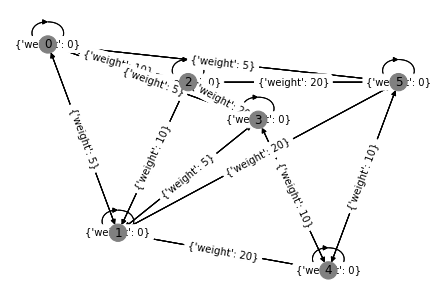

In [4]:
def plot_graph(graph, labels_on=True):
    node_pos=nx.get_node_attributes(graph,'pos')
#     edge_types = [graph.get_edge_data(*edge)['edge_type'] for edge in graph.edges()]
#     edge_cols = ['blue' if t == 'route1' else 'red' for t in edge_types]
    node_colors= []
    for node in list(G.nodes(data=True)):
        node_colors.append(node[1]["node_color"])
#     node_colors=["blue" if node == "blue" else "gray" for node in list(graph.nodes(data=True))[node-1][1]["node_color"] ]

    nx.draw(graph, with_labels=True, node_size = 300, pos=node_pos, node_color=node_colors)
    nx.draw_networkx_edges(graph, node_pos) #, edge_color=edge_cols)
    if labels_on:
        nx.draw_networkx_edge_labels(graph, node_pos)

    plt.show()

plot_graph(G)

## 2. BUILD GENERATIVE MODEL

### Set up states, observations, and actions

In [5]:
def state_space_from_graph(graph):
    states = {"node_pair": list(graph.edges)}
    observations = {
        "pair_plus_edge_weight": 
        list([[edge, graph.get_edge_data(edge[0], edge[1])["weight"]] for edge in list(graph.edges)])
    }
    actions = {"change_location": 
        [edge for edge in list(itertools.product(list(graph.edges),repeat=2)) 
        if edge[0][1] == edge[1][0]]
    }
    
    # Handy variables for dimensions of state space
    num_state_factors = len(states)
    num_states = [len(states[factor]) for factor in states]
    num_modalities = len(observations)
    num_observations = [len(observations[modality]) for modality in observations]
    num_actions = len(actions['change_location'])
    
    # Summarize edge weights in a variable
    weights = np.array([obs[1] for obs in observations['pair_plus_edge_weight']])
    
    return states, observations, actions, num_state_factors, num_states, num_modalities, num_observations, num_actions, weights

states, observations, actions, num_state_factors, num_states, num_modalities, num_observations, num_actions, weights = state_space_from_graph(G)

# Determines how much weight the edge weights carry in the EFE calculation - free hyperparameter
weight_coefficient = 5


### Set up policies

In [6]:
# Use multiprocessing but it doesn't work
def find_paths_all_nodes_multi(graph, policy_len):
    paths = []
    with Pool() as p:
        paths += p.starmap_async(find_paths_recursive, [(graph, n, policy_len) for n in graph.nodes()])
    return paths        


def find_paths_all_nodes_multi(graph, policy_len):
    paths = []
    pool = Pool()
    for n in graph.nodes():
        paths.append(pool.apply_async(find_paths_recursive, [graph, n, policy_len]))
    results = [path.get() for path in paths]
    pool.close()
    
    return results


def find_paths_recursive(graph,u,n):
    if n==0:
        return [[u]]
    paths = [[u]+path for neighbor in graph.neighbors(u) for path in find_paths_recursive(graph,neighbor,n-1)]
    return paths


def find_paths_all_nodes(graph, policy_len):
    paths = []
    for n in tqdm(graph.nodes()):
        paths += find_paths_recursive(graph, n, policy_len) #len(list(graph.nodes())))
    return paths


def convert_to_edges(paths):
    path_edges = []
    for path in tqdm(paths):
        one_path_edges = []
        for idx,node in enumerate(path[1:]):
            one_path_edges.append((path[idx],path[idx+1]))
        path_edges.append(one_path_edges)
    
    return path_edges


def convert_to_policies(edge_sets, actions, policy_len, num_controllable_factors):
    path_policies = []
    for edge_set in tqdm(edge_sets):
        edge_actions = []
        for idx, edge_tuple in enumerate(edge_set[1:]):
            edge_actions.append(actions['change_location'].index((edge_set[idx], edge_set[idx+1])))
        path_policies.append(np.array(edge_actions).reshape(policy_len, num_controllable_factors))
    
    return path_policies


def get_policies_from_graph(graph, actions, num_controllable_factors, policy_len=None, use_pool=True):
    """
    Get all policies on graph that are 'well-formed', i.e. only actions that begin 
    on the node that the previous action ended at are used
    """
    if not policy_len:
        policy_len = len(list(graph.nodes()))
    print("Getting paths recursively...")
    if use_pool:
        paths = find_paths_all_nodes_multi(graph, policy_len+1)
    else:
        paths = find_paths_all_nodes(graph, policy_len+1)
    print("Getting edges...")
    path_edges = convert_to_edges(paths)
    print("Getting policies...")
    return np.array(convert_to_policies(path_edges, actions, policy_len, num_controllable_factors))



### Older way of doing it -- still worth keeping around (generate all possible permutations then trim based on semantics)
def get_policies_trimmed(controls, n_states, n_control=None, policy_len=1, control_fac_idx=None):
    """
    This is an adapted version of pymdp's `construct_policies` that prunes away usless
    policies (those with "illegal" state transitions) and returns policies as an np.array
    """
   
    # This stuff just copied from pymdp
    n_factors = len(n_states)
    if control_fac_idx is None:
        control_fac_idx = list(range(n_factors))
    return_n_control = False

    if n_control is None:
        return_n_control = True
        n_control = []
        for c_idx in range(n_factors):
            if c_idx in control_fac_idx:
                n_control.append(n_states[c_idx])
            else:
                n_control.append(1)
        n_control = list(np.array(n_control).astype(int))
    x = n_control * policy_len
    
    policies = list(itertools.product(*[list(range(i)) for i in x]))
    trimmed_policies = []
    if policy_len > 1:
        for pol_i in range(len(policies)):
            
            # This gets the actual states (tuples) in the policy
            expanded_policy = [controls['change_location'][idx] for idx in policies[pol_i]]
            
            # Loop over those states (up until the last one) and check whether the policy is degenerate
            if is_invalid(expanded_policy):
                continue
            trimmed_policies.append(np.array(policies[pol_i]).reshape(policy_len, n_factors))
    else:
        for pol_i in range(len(policies)):
            policies[pol_i] = np.array(policies[pol_i]).reshape(1, n_factors)

    if return_n_control:
        return np.array(trimmed_policies), n_control
    else:
        return np.array(trimmed_policies)


# For debugging purposes
def get_policies(n_states, n_actions, policy_len):
    return control.construct_policies(n_states, n_actions, policy_len)


# Helper for `get_policies`
def is_invalid(exp_policy):
    for idx, term in enumerate(exp_policy[:-1]):
        
        # If last node of one action != first node of next, don't add policy to list
        if term[1] != (exp_policy[idx+1][0]):
            return True
    return False
            

# Set policy length and get the initial list of policies
policy_len = len(list(G.nodes()))
# policies = get_policies(num_states, [num_actions], policy_len)
#all_policies = get_policies_trimmed(actions, num_states, [num_actions], policy_len)
t1 = time.time()
all_policies = get_policies_from_graph(G, actions, num_state_factors, use_pool=False)
duration = time.time() - t1
print(f"Execution time: {duration}")

# t1 = time.time()
# all_policies = get_policies_from_graph(G, actions, num_state_factors)
# duration = time.time() - t1
# print(f"Multiprocessing execution time: {duration}")




Getting paths recursively...


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.10it/s]


Getting edges...


100%|███████████████████████████████| 507842/507842 [00:01<00:00, 449414.52it/s]


Getting policies...


100%|████████████████████████████████| 507842/507842 [00:07<00:00, 72084.66it/s]


Execution time: 9.962080001831055


## A Unit Test

In [12]:
# Ensure that the graph-based policy generator works the same as the older method

# expected = get_policies_trimmed(actions, num_states, [num_actions], policy_len)
# actual = get_policies_from_graph(G, actions, num_state_factors)

# assert np.all(expected == actual)


Getting paths recursively...


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1811.60it/s]


Getting edges...


100%|███████████████████████████████████| 2258/2258 [00:00<00:00, 638921.84it/s]


Getting policies...


100%|███████████████████████████████████| 2258/2258 [00:00<00:00, 202708.38it/s]


### Set up matrices
#### A Matrix

In [7]:
# A structure = [observation_modality][observation_level, state_factor_1, ..., state_factor_n]
def A_setup(num_states, num_state_factors):
    # For now assuming just one observation modality
    return np.array([
        np.eye(num_states[factor]) for factor in range(num_state_factors)
    ], dtype='object')

A = A_setup(num_states, num_state_factors)

#### B Matrix

In [8]:
# B structure = [state_factor][current_state, previous_state, action]
def B_setup(states, graph, num_states, num_state_factors, num_actions):
    B = np.array([
        np.zeros((num_states[factor], num_states[factor], num_actions))
        for factor in range(num_state_factors)
    ], dtype='object')

    # Fill out values for valid moves
    for factor_idx, factor in enumerate(states):
        for prev_idx in range(num_states[factor_idx]):
            for current_idx in range(num_states[factor_idx]):
                for action_idx in range(num_actions):
                    if (
                        states['node_pair'][prev_idx], 
                        states['node_pair'][current_idx]
                    ) == actions['change_location'][action_idx]:
                        if actions['change_location'][action_idx][0] in list(graph.edges):
                            B[factor_idx,current_idx,prev_idx,action_idx] = 1.
                        else:
                            resulting_state_idx = states['node_pair'].index(
                                (states['node_pair'][prev_idx][1], 
                                 states['node_pair'][prev_idx][1])
                            )
                            B[factor_idx,resulting_state_idx,prev_idx,action_idx] = 1.
                    else:
                        if states['node_pair'][prev_idx] != actions['change_location'][action_idx][0]:
                            resulting_state_idx = states['node_pair'].index(
                                (states['node_pair'][prev_idx][1], 
                                 states['node_pair'][prev_idx][1])
                            )
                            B[factor_idx,resulting_state_idx,prev_idx,action_idx] = 1.
    return B

B = B_setup(states, G, num_states, num_state_factors, num_actions)

#### C Matrix

In [9]:
def C_setup(states, num_states, desired_state_idx=None):
    # For now, assume just one observation modality
    C = np.array([
        np.zeros(num_states[idx]) for idx, factor in enumerate(states)
    ], dtype = 'float32')

    if desired_state_idx:
        print("destination", desired_state_idx)
        destination = desired_state_idx
    else:
        # Choose a random destination node
        destination = np.random.randint(len(list(G.nodes)))
        print("destination", destination)

    # Distribute positive preferences over paths that terminate at this destination
    desired_indices = np.where(
        np.array([states['node_pair'][state][1] for state in range(num_states[0])]) 
        == destination
    )[0]
    
    print("Desired indices", desired_indices)
    if len(desired_indices) > 0:
        C[0][desired_indices] = 1./len(desired_indices)
    else:
        print("Destination unreachable. C matrix is flat")
        C[0] += 1./C[0].shape[0]
    
    return C

#desired_node = 5
#C = C_setup(states, num_states, desired_node)
desired_node = 3
C = C_setup(states, num_states, desired_node) # Random desired node

# TODO : Sometimes this returns a flat C matrix ("destination unreachable") -- fix this if possible

destination 3
Desired indices [ 1  6 14 20 22]


#### D Matrix / initial conditions

In [10]:
# Initial state distribution
def D_setup(num_states, num_state_factors, initial_state=(1,1)):

    initial_beliefs = np.array([
        np.zeros(num_states[factor_idx])
        for factor_idx in range(num_state_factors)
    ])
    initial_beliefs[0][states['node_pair'].index(initial_state)] = 1.
    
    return initial_beliefs

initial_beliefs = D_setup(num_states, num_state_factors, initial_state=(0,0))
# initial_beliefs = D_setup(num_states, num_state_factors, initial_state=(1,1))


## 3. BREAKING TRACKS
To simulate disruptions to the transit system, we can removed edges from the generative process graph at each timestep, or put them back.

### Update graphs

In [11]:
# Change the gen. process graph
def remove_edges(graph):
    removable_edges = [edge for edge in list(graph.edges()) if edge[0] != edge[1]]
    
    if len(removable_edges) > 0:

        chance = randint(0,10)
        if chance < 10:
            randomness = sample(removable_edges, 1)[0]

            edge_data = graph.get_edge_data(*randomness)
            removed_edge = {key: value for key, value in zip(edge_data.keys(), edge_data.values())}
            removed_edge['edge'] = randomness
            graph.removed_edges.append(removed_edge)
            graph.remove_edge(*randomness)

            print("Removed the edge: " , randomness)
    else:
        print("Attempted to remove an edge--no edges to remove.")
    
    
def restore_edges(graph):
    chance = randint(0,10)
    if chance < 3:
        if len(graph.removed_edges) > 0:
            print("grm", graph.removed_edges)
            randomness = sample(graph.removed_edges, 1)[0]
            
            print("randomness", randomness)
            graph.add_edge(*randomness['edge'],  weight=randomness['weight']) #edge_type=randomness['edge_type'],
            graph.removed_edges.remove(randomness)
            
            print("Restored the edge:", randomness['edge'])
        else:
            print("Attempted to restore an edge--none missing.")


# Change the agent graph + gen. model
def update_agent_graph(agent_location, agent_graph, gp_graph):
    """
    Update the agent's internal graph representation based on the edges
    observable from its current position
    """
    
    # For all nodes in actual graph (other than the agent's current location):
    for node in [node for node in gp_graph.nodes if node != agent_location]:
        edge_to_check = (agent_location, node)
        if not gp_graph.has_edge(*edge_to_check):
        #    If no edge-between-nodes in real_graph:
            if agent_graph.has_edge(*edge_to_check):
                #    Delete edge            
#                 edge_data = agent_graph.get_edge_data(*edge_to_check)
#                 removed_edge = {key: value for key, value in zip(edge_data.keys(), edge_data.values())}
#                 removed_edge['edge'] = edge_to_check
                agent_graph.removed_edges.append(edge_to_check)
                agent_graph.remove_edge(*edge_to_check)
        else:
        #    If edge-between-nodes in real_graph:
            if not agent_graph.has_edge(*edge_to_check):
                #    Add it if it doesn't exist
                to_add = gp_graph.get_edge_data(*edge_to_check)
                agent_graph.add_edge(agent_location,node,  weight=to_add['weight']) #edge_type=to_add['edge_type'],
                agent_graph.removed_edges.remove(edge_to_check)


### Update policies
We need to update the policy list at each timestep. To do this efficiently, we organize policy indices by edge in a dictionary

In [12]:
# Organizing policies by edge helps us do this efficiently
def get_policy_idx_dict(controls, graph, policies_trimmed):
    edges = list(graph.edges())
    policy_idx_dict = {edge: set() for edge in edges}
    for policy_idx, policy in enumerate(policies_trimmed):        
        expanded_policy = [
            controls['change_location']
            [policies_trimmed[policy_idx][idx][0]] 
            for idx in range(len(policies_trimmed[policy_idx]))
        ]
        for action in expanded_policy:
            for edge in edges:
                if edge in action:
                    policy_idx_dict[edge].add(policy_idx)
                    
    # Return the dict, and also a set of all the policy indices (so that we don't have to re-compute this)
    graph.policy_idx_dict = policy_idx_dict
    graph.all_policy_indices = set(range(len(policies_trimmed)))
    return policy_idx_dict, graph.all_policy_indices

# Update policy list, given removed or restored graph edges
def update_policies(agent_graph, all_policies):
    active_policy_indices = agent_graph.all_policy_indices
    for removed_edge in agent_graph.removed_edges:
        active_policy_indices = active_policy_indices.difference(agent_graph.policy_idx_dict[removed_edge])
    
    return all_policies[list(active_policy_indices)]
        
    
# These get assigned as properties of the graph as well - TODO : Create special graph class and move this to __init__
policy_idx_dict, all_policy_indices = get_policy_idx_dict(actions, G, all_policies)


### Update generative model/process, given (potentially) changed graphs

In [13]:
def update_agent(agent_graph, policy_len, all_policies, state, state_history, weight_coefficient, desired_state_idx=None):
    """
    Re-build the policy space and generative model, given the agent's graph    
    """
    policies = update_policies(agent_graph, all_policies)    
    A = A_setup(num_states, num_state_factors)
    B = B_setup(states, agent_graph, num_states, num_state_factors, num_actions)
    C = C_setup(states, num_states, desired_state_idx)
    
    if states['node_pair'][state_history[-1]][1] == \
    states['node_pair'][state][0] == \
    states['node_pair'][state][1] and states['node_pair'][state_history[-1]][1] != desired_node:
        weight_coefficient = np.max(weight_coefficient - 1, 0)
        
    return A, B, C, policies, weight_coefficient


def update_gp(graph, states, num_states, num_state_factors, num_actions):
    """
    Re-build the A and B matrices for the generative process, given the world graph
    """
    A_gp = A_setup(num_states, num_state_factors)
    B_gp = B_setup(states, graph, num_states, num_state_factors, num_actions)
    
    return A_gp, B_gp



## 3. SIMULATION SETUP
Functions adapted from the pymdp-mooc notebook


#### Functions for inference

In [14]:
def select_policy_kmeans(cluster_centers, clusters, policies_list, Qs, A, B, C, weights, weight_coefficient):
    print("cluster centers", cluster_centers)
    cluster_EFEs = []
    for cluster_center in cluster_centers:
        cluster_EFEs.append(
            evaluate_policy(policies_list[cluster_center], Qs, A, B, C, weights, weight_coefficient)
        )
    chosen_cluster_idx = np.argmin(cluster_EFEs)
    print("chosen-idx", chosen_cluster_idx)
    
    return clusters[chosen_cluster_idx]


In [15]:
def infer_action(policies, Qs, A, B, C, n_states, n_actions, policy_len, weights, weight_coefficient):
    
    n_policies = len(policies)
    
    # initialize the negative expected free energy
    neg_G = np.zeros([n_policies, 1])

    # loop over every possible policy and compute the EFE of each policy
    for i, policy in enumerate(policies):
        neg_G[i] = evaluate_policy(policy, Qs, A, B, C, weights=weights, weight_coefficient=weight_coefficient)        
        #print([actions['change_location'][policies[i][idx][0]] for idx in range(4)], neg_G[i])

    # get distribution over policies
    Q_pi = softmax(neg_G)
        
    # initialize probabilites of control states (convert from policies to actions)
    Qu = np.zeros(n_actions)
    
    # sum probabilites of controls
    
    # TODO : Figure out a better way to select actions
    
    for i, policy in enumerate(policies):
        # control state specified by policy
        u = int(policy[0])
        # add probability of policy
        Qu[u] += Q_pi[i]
        
    # normalize
    Qu /= np.sum(Qu)

    for i in range(len(policies[:10])):
        print("EFE", neg_G[i], "softmax", Q_pi[i])
    for j in range(n_actions[0]):
        print("action", actions["change_location"][j], "control prob", Qu[j])


    # sample control - ALEX: Not sure how this is usually done in new pymdp w/o Categorical class
    u = np.where(np.random.multinomial(1, Qu))[0][0]

    return u, neg_G


#coefficient = 0.225

def evaluate_policy(policy, Qs, A, B, C, weights, weight_coefficient):
    # initialize expected free energy at 0
    G = 0
    
    # create copy of our state
    Qs_copy = copy.deepcopy(Qs)
        
    # loop over policy
    for t in range(len(policy)):

        # get action
        u = int(policy[t])

        # work out expected state
        Qs = B[:,:,u].dot(Qs)
            
        # work out expected observations
        Qo = A.dot(Qs)
        # get entropy - ALEX: Again, can't rely on Categorical here so using scipy
        H = entropy(np.float32(A))

        # get predicted divergence and uncertainty and novelty - ALEX: Scipy's entropy does KL div too
        divergence = entropy(np.float32(Qo) + 1e-16, np.float32(C) + 1e-16)
        uncertainty = H.dot(Qs)
        # increment the expected free energy counter. Add coefficient-weighted expected edge weight
        G += (divergence + uncertainty + (np.dot(weights, Qo)*(weight_coefficient)))

#         G += ((divergence*coefficient) + uncertainty + (np.dot(weights, Qo)*(1-coefficient)))

    return -G


#### Function to plot beliefs

In [16]:
# From pymdp-mooc notebook
def plot_beliefs(Qs, title=""):
    plt.grid(zorder=0)
    plt.bar(range(Qs.shape[0]), Qs, color='r', zorder=3)
    plt.xticks(range(Qs.shape[0]))
    plt.title(title)
    plt.show()


#### Initial conditions

In [17]:
# Initial state reflects belief
state = np.argmax(initial_beliefs[0])

# Initial observation of self at (1,1), edge weight 5 (here we just get the index of this obs)
observation_idx = observations['pair_plus_edge_weight'].index([(1,1),0])

# Edges
init_edges = list(G.edges())


#### Make generative process (a copy of the generative model)

In [18]:
A_gp = copy.deepcopy(A)
B_gp = copy.deepcopy(B)

# Set initial graph to be a copy of the agent's generative model
G_gp = copy.deepcopy(G)



## K-means

In [19]:
# First try a similarity metric that doesn't take node position (in path) into account
# But may want to re-introduce

def expand(policy):
    return [actions["change_location"][x[0]] for x in policy]


def extract_edges(policy):
    result = []  
    for action in expand(policy):
        result += [action[0], action[1]]
    return set(result)

def extract_nodes(edges):
    result = []
    for edge in edges:
        result += [edge[0], edge[1]]
    return set(result)

# def similarity1(policy1, policy2):
#     policy1_edges = extract_edges(policy1)
#     policy1_nodes = extract_nodes(policy1_edges)
    
#     policy2_edges = extract_edges(policy2)
#     policy2_nodes = extract_nodes(policy2_edges)
        
#     return len(policy1_edges.intersection(policy2_edges)) \
#     + len(policy1_nodes.intersection(policy2_nodes))

def edit_distance(graph_A, graph_B):
    
    A_edges, B_edges = extract_edges(graph_A), extract_edges(graph_B)
    diff_edges = distinct_elements(A_edges, B_edges)
    
    A_nodes, B_nodes = extract_nodes(A_edges), extract_nodes(B_edges)
    diff_nodes = distinct_elements(A_nodes, B_nodes)
    
    return len(diff_edges) + len(diff_nodes)

    
def distinct_elements(set_A, set_B):
    return set_A.union(set_B) - set_A.intersection(set_B)


def edit_distance_matrix(policies):
    num_policies = len(policies)
    matrix = np.zeros((num_policies, num_policies), dtype='int')
    for i in tqdm(range(num_policies)):
        for j in range(num_policies):
            matrix[i,j] = edit_distance(policies[i], policies[j])
    return matrix
            

### Create edit distance matrix

In [38]:
#matrix = edit_distance_matrix(all_policies)

  0%|                                  | 125/206362 [03:52<106:44:19,  1.86s/it]

KeyboardInterrupt



### Run k-means on edit distance matrix

In [129]:
#kmeans_unreduced = KMeans(n_clusters=12, random_state=0).fit(matrix)
#kmeans_unreduced.cluster_centers_

#kmeans_unreduced.cluster_centers_[0]

array([ 9.19354839,  9.19354839, 10.19354839, 10.19354839,  7.35483871,
        8.83870968, 10.19354839, 10.19354839, 10.19354839, 10.19354839,
       10.19354839, 11.19354839,  8.35483871,  6.51612903,  7.        ,
        9.83870968,  7.        ,  8.83870968, 10.19354839, 10.19354839,
       11.19354839, 11.19354839,  8.35483871,  9.83870968, 10.19354839,
       10.19354839, 10.19354839, 10.19354839, 10.19354839, 11.19354839,
        9.19354839,  7.35483871,  8.83870968, 11.19354839, 10.19354839,
       10.19354839,  7.35483871,  8.35483871,  8.35483871,  6.51612903,
        5.51612903,  5.16129032,  7.        ,  5.16129032,  6.        ,
        9.83870968,  8.83870968,  9.83870968,  7.        ,  5.16129032,
        5.64516129,  8.83870968,  6.        ,  7.83870968, 10.19354839,
       10.19354839, 10.19354839, 11.19354839,  8.35483871,  9.83870968,
       11.19354839, 11.19354839, 11.19354839, 11.19354839, 10.19354839,
       10.19354839,  8.35483871,  6.51612903,  7.        ,  9.83

### Run k-means on bag of policies

In [20]:
#def bag_of_policies(policies):
    #return [list(extract_edges(policy)) for policy in tqdm(policies)]
    
def bag_of_policies(graph, policies):
    bag = []
    for policy in tqdm(policies):
        bag.append(np.array([list(extract_edges(policy)).count(edge) for edge in graph.edges()]))
    
    return bag



In [21]:
bop = bag_of_policies(G, all_policies)

100%|████████████████████████████████| 507842/507842 [00:50<00:00, 10054.68it/s]


In [22]:
kmeans_bop = KMeans(n_clusters=12, random_state=0).fit(np.array(bop))
kmeans_bop.cluster_centers_

kmeans_bop.cluster_centers_[0]

array([0.27026288, 0.09251955, 0.09479948, 0.10879825, 0.09648663,
       0.17767493, 0.19208408, 0.99051549, 0.16914799, 0.23435398,
       0.37867354, 0.09331753, 0.11636762, 0.24278972, 0.05907298,
       0.07681083, 0.16962678, 0.06614076, 0.09370511, 0.06566198,
       0.04639657, 0.61991291, 0.00305511, 0.49604432, 0.3084061 ,
       0.15127334, 0.38104466, 0.15446524, 0.17254509, 0.17081234])

### Create cluster and cluster center variables

In [23]:
def get_agent_kmeans(policies, embedding, kmeans):

    closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, embedding)
    agent_cluster_centers = closest

    agent_clusters = [
        [policy for idx, policy in enumerate(policies) if kmeans.labels_[idx] == cluster_idx]
        for cluster_idx in range(len(agent_cluster_centers))
    ]
    
    return agent_clusters, agent_cluster_centers

agent_clusters, agent_cluster_centers = get_agent_kmeans(all_policies, bop, kmeans_bop)

# TODO : Try word2vec - style embeddings
# TODO : Try bag of words/policies
# TODO : Try bigrams/trigrams

# TODO : Try running the original solution on GPU / parallelized

## 4. RUN SIMULATION

Initial beliefs [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
C matrix [[0.  0.2 0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.
  0.  0.  0.2 0.  0.2 0.  0.  0.  0.  0.  0.  0. ]]
Agent's internal graph:


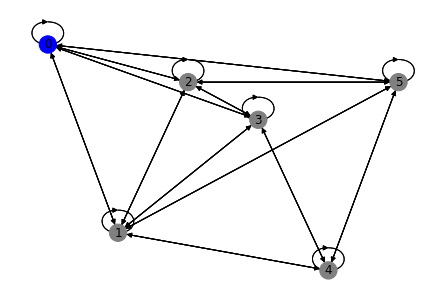

Real-world (generative process) graph:


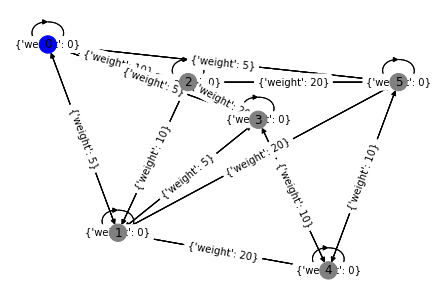


------------------------
Timestep  0
State: (0, 0)
cluster centers [122321  37759  97866 105137 125148 407246 247166  30834   9288  55668
 142976  94152]
chosen-idx 0
EFE [-221.048172] softmax [9.00060375e-21]
EFE [-221.048172] softmax [9.00060375e-21]
EFE [-221.048172] softmax [9.00060375e-21]
EFE [-221.048172] softmax [9.00060375e-21]
EFE [-221.048172] softmax [9.00060375e-21]
EFE [-221.048172] softmax [9.00060375e-21]
EFE [-221.048172] softmax [9.00060375e-21]
EFE [-221.048172] softmax [9.00060375e-21]
EFE [-221.048172] softmax [9.00060375e-21]
EFE [-221.048172] softmax [9.00060375e-21]
action ((0, 1), (1, 2)) control prob 1.2960869398287356e-18
action ((0, 1), (1, 3)) control prob 1.4941002223025706e-18
action ((0, 1), (1, 4)) control prob 2.2606646319617305e-15
action ((0, 1), (1, 5)) control prob 1.2780857323311142e-18
action ((0, 1), (1, 0)) control prob 1.6291092785347308e-18
action ((0, 1), (1, 1)) control prob 5.04563065325652e-16
action ((0, 3), (3, 1)) control prob 3.74425

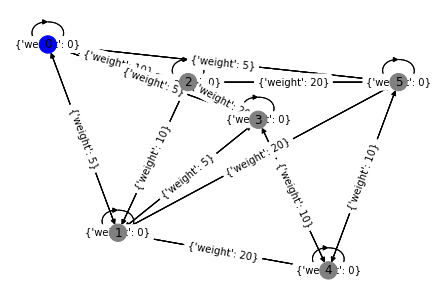

current state 0
Agent's internal graph:


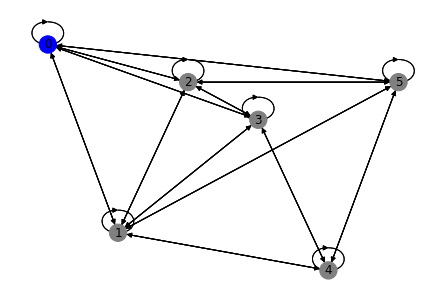

destination 3
Desired indices [ 1  6 14 20 22]
Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33]


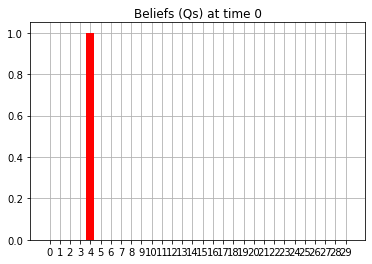


------------------------
Timestep  1
State: (0, 0)
cluster centers [122321  37759  97866 105137 125148 407246 247166  30834   9288  55668
 142976  94152]
chosen-idx 0
EFE [-221.048172] softmax [6.06455909e-23]
EFE [-221.048172] softmax [6.06455909e-23]
EFE [-221.048172] softmax [6.06455909e-23]
EFE [-221.048172] softmax [6.06455909e-23]
EFE [-221.048172] softmax [6.06455909e-23]
EFE [-221.048172] softmax [6.06455909e-23]
EFE [-221.048172] softmax [6.06455909e-23]
EFE [-221.048172] softmax [6.06455909e-23]
EFE [-221.048172] softmax [6.06455909e-23]
EFE [-221.048172] softmax [6.06455909e-23]
action ((0, 1), (1, 2)) control prob 8.73296508889414e-21
action ((0, 1), (1, 3)) control prob 1.0067168088586297e-20
action ((0, 1), (1, 4)) control prob 2.2500707779619173e-15
action ((0, 1), (1, 5)) control prob 8.611673907103945e-21
action ((0, 1), (1, 0)) control prob 1.0976851952012769e-20
action ((0, 1), (1, 1)) control prob 5.000305055159606e-16
action ((0, 3), (3, 1)) control prob 2.5228565

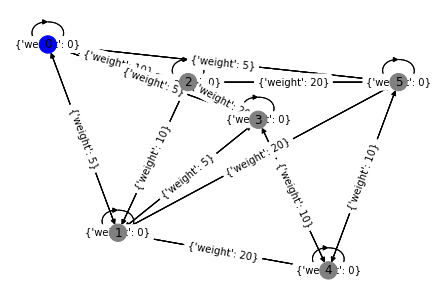

current state 0
Agent's internal graph:


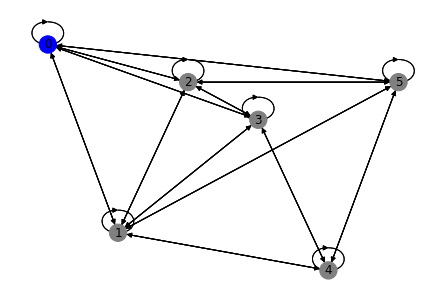

destination 3
Desired indices [ 1  6 14 20 22]
Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33]


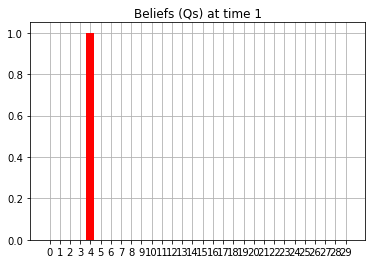


------------------------
Timestep  2
State: (0, 0)
cluster centers [122321  37759  97866 105137 125148 407246 247166  30834   9288  55668
 142976  94152]
chosen-idx 0
EFE [-221.048172] softmax [4.08626653e-25]
EFE [-221.048172] softmax [4.08626653e-25]
EFE [-221.048172] softmax [4.08626653e-25]
EFE [-221.048172] softmax [4.08626653e-25]
EFE [-221.048172] softmax [4.08626653e-25]
EFE [-221.048172] softmax [4.08626653e-25]
EFE [-221.048172] softmax [4.08626653e-25]
EFE [-221.048172] softmax [4.08626653e-25]
EFE [-221.048172] softmax [4.08626653e-25]
EFE [-221.048172] softmax [4.08626653e-25]
action ((0, 1), (1, 2)) control prob 5.884223803513829e-23
action ((0, 1), (1, 3)) control prob 6.783202440161784e-23
action ((0, 1), (1, 4)) control prob 2.2499988654376858e-15
action ((0, 1), (1, 5)) control prob 5.80249847290947e-23
action ((0, 1), (1, 0)) control prob 7.39614241969448e-23
action ((0, 1), (1, 1)) control prob 4.999998134546269e-16
action ((0, 3), (3, 1)) control prob 1.6998868765

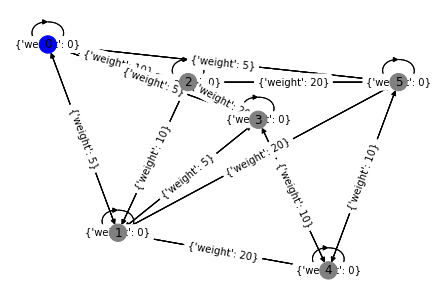

current state 0
Agent's internal graph:


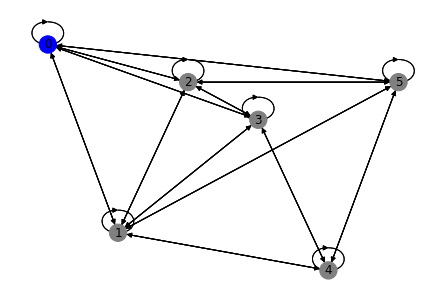

destination 3
Desired indices [ 1  6 14 20 22]
Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33]


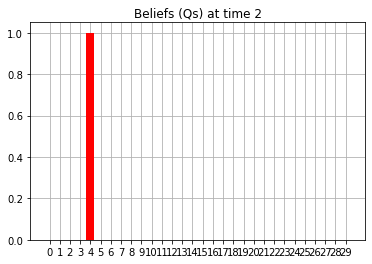


------------------------
Timestep  3
State: (0, 0)
cluster centers [122321  37759  97866 105137 125148 407246 247166  30834   9288  55668
 142976  94152]
chosen-idx 0
EFE [-221.048172] softmax [2.75318058e-27]
EFE [-221.048172] softmax [2.75318058e-27]
EFE [-221.048172] softmax [2.75318058e-27]
EFE [-221.048172] softmax [2.75318058e-27]
EFE [-221.048172] softmax [2.75318058e-27]
EFE [-221.048172] softmax [2.75318058e-27]
EFE [-221.048172] softmax [2.75318058e-27]
EFE [-221.048172] softmax [2.75318058e-27]
EFE [-221.048172] softmax [2.75318058e-27]
EFE [-221.048172] softmax [2.75318058e-27]
action ((0, 1), (1, 2)) control prob 3.964580033057205e-25
action ((0, 1), (1, 3)) control prob 4.570279760329831e-25
action ((0, 1), (1, 4)) control prob 2.2499194735742473e-15
action ((0, 1), (1, 5)) control prob 3.909516421486966e-25
action ((0, 1), (1, 0)) control prob 4.983256847106622e-25
action ((0, 1), (1, 1)) control prob 4.999770617043957e-16
action ((0, 3), (3, 1)) control prob 1.14532312

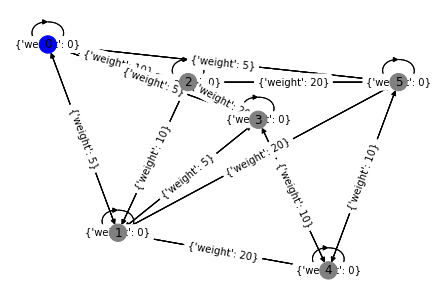

current state 0
Agent's internal graph:


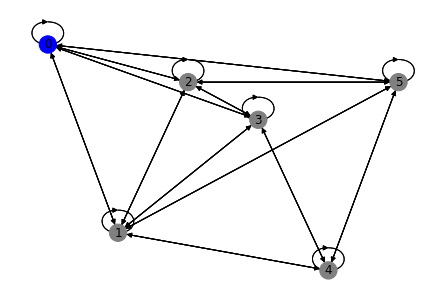

destination 3
Desired indices [ 1  6 14 20 22]
Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33]


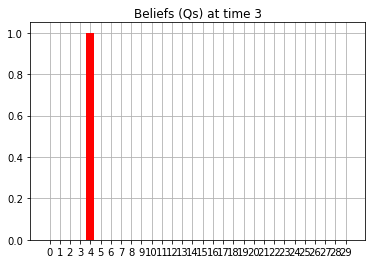


------------------------
Timestep  4
State: (0, 0)
cluster centers [122321  37759  97866 105137 125148 407246 247166  30834   9288  55668
 142976  94152]
chosen-idx 0
EFE [-221.048172] softmax [1.84269398e-29]
EFE [-221.048172] softmax [1.84269398e-29]
EFE [-221.048172] softmax [1.84269398e-29]
EFE [-221.048172] softmax [1.84269398e-29]
EFE [-221.048172] softmax [1.84269398e-29]
EFE [-221.048172] softmax [1.84269398e-29]
EFE [-221.048172] softmax [1.84269398e-29]
EFE [-221.048172] softmax [1.84269398e-29]
EFE [-221.048172] softmax [1.84269398e-29]
EFE [-221.048172] softmax [1.84269398e-29]
action ((0, 1), (1, 2)) control prob 2.6534793315857944e-27
action ((0, 1), (1, 3)) control prob 3.058872007244442e-27
action ((0, 1), (1, 4)) control prob 2.2382227923289e-15
action ((0, 1), (1, 5)) control prob 2.6166254519801834e-27
action ((0, 1), (1, 0)) control prob 3.33527611139459e-27
action ((0, 1), (1, 1)) control prob 4.966392141421653e-16
action ((0, 3), (3, 1)) control prob 7.6656069579

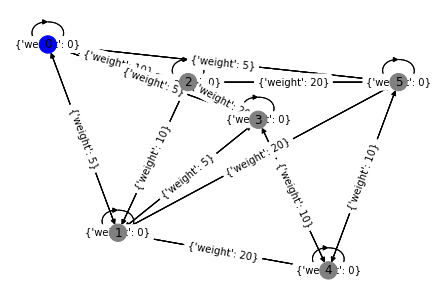

current state 0
Agent's internal graph:


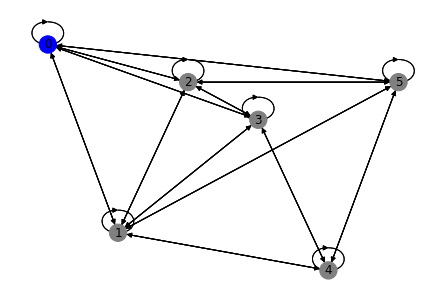

destination 3
Desired indices [ 1  6 14 20 22]
Beliefs:  [9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 1.00000e+00 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33
 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33 9.99999e-33]


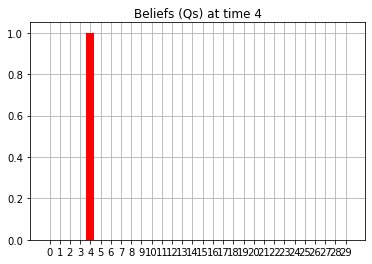


------------------------
Timestep  5
State: (0, 0)
cluster centers [122321  37759  97866 105137 125148 407246 247166  30834   9288  55668
 142976  94152]
chosen-idx 0


KeyboardInterrupt: 

In [24]:
T = 10 # Number of timesteps

desired_node = 3
s = state
state_history = [s]
b = initial_beliefs[0]
policies = all_policies

# Plot initial state data
nx.set_node_attributes(G, "grey", name="node_color")
nx.set_node_attributes(G, {states['node_pair'][s][1]: "blue"}, name="node_color")

print("Initial beliefs", b)
print("C matrix", C)

print("Agent's internal graph:")
plot_graph(G, labels_on=False)

print("Real-world (generative process) graph:")
plot_graph(G_gp)
# print('g edges',list(G.edges))
# print('g_gp edges',list(G_gp.edges))



for timestep in range(T):
    print("")
    print("------------------------")
    print("Timestep ", timestep)

    print(f"State: {states['node_pair'][s]}")
    cluster_policies = select_policy_kmeans(agent_cluster_centers, agent_clusters, all_policies, b, A[0], B[0], C[0], weights, weight_coefficient)
    a, EFE = infer_action(cluster_policies, b, A[0], B[0], C[0], num_states, [num_actions], policy_len, weights, weight_coefficient)    
    
    #a, EFE = infer_action(policies, b, A[0], B[0], C[0], num_states, [num_actions], policy_len, weights, weight_coefficient)    
    a = int(a)
    
    print(f"Action: {actions['change_location'][a]} (index {a})")
    print("Chosen policy's EFE", EFE[a])
    
    # perform action in the environment and update the environment
    s = utils.sample(np.float32(B_gp)[0][:, s, a])
    print(f"New state: {states['node_pair'][s]}")
    o = utils.sample(np.float32(A_gp)[0][:,s])
    print(f"Observation: {observations['pair_plus_edge_weight'][o]}")

    # keep a running record of states
    state_history.append(s)


#     # For now, hard-code breaking (2,5) at timestep 0
#     if timestep == 0:
#         edge_data = G_gp.get_edge_data(2,5)
#         removed_edge = {key: value for key, value in zip(edge_data.keys(), edge_data.values())}
#         removed_edge['edge'] = (2,5)
#         G_gp.removed_edges.append(removed_edge)
#         G_gp.remove_edge(2,5)

    
    # Remove or restore an edge with some probability and look at graph
    # TODO : Turn this back on
    
    #restore_edges(G_gp)
    #remove_edges(G_gp)    
    
    # Plot it
    print("Real-world (generative process) graph:")
    nx.set_node_attributes(G, "grey", name="node_color")
    nx.set_node_attributes(G, {states['node_pair'][s][1]: "blue"}, name="node_color")
    plot_graph(G_gp)
    
    # Update generative process
    A_gp, B_gp = update_gp(G_gp, states, num_states, num_state_factors, num_actions)
#     print('g edges',list(G.edges))
#     print('g_gp edges',list(G_gp.edges))
        
    # Update agent's internal graph, state space, and policy list
    print("current state", states['node_pair'][s][1])
    update_agent_graph(states['node_pair'][s][1], G, G_gp)
    
    # Plot agent graph
    print("Agent's internal graph:")
    plot_graph(G, labels_on=False)

    # Update agent's model parameters
    A, B, C, policies, weight_coefficient = update_agent(G, policy_len, all_policies, s, state_history, weight_coefficient, desired_node)

    # infer new hidden state
    b = softmax(np.log(np.float32(A[0][o,:]) + 1e-16) + np.log(np.float32(B[0][:,:,a].dot(b)) + 1e-16))
    print(f"Beliefs: ", b)
    
    plot_beliefs(b, "Beliefs (Qs) at time {}".format(timestep))
    


In [85]:
agent_cluster_centers

array([ 79536,  33327,  36171,  88709,   4145,  43709,  41628,  87418,
         9695, 181009,  61139,  12222])

## 2D PCA / K-means visualization

In [86]:
agent_clusters[0]

[array([[ 0],
        [18],
        [72],
        [ 0],
        [21],
        [86]]),
 array([[ 0],
        [18],
        [74],
        [12],
        [86],
        [41]]),
 array([[ 0],
        [18],
        [74],
        [12],
        [86],
        [42]]),
 array([[ 0],
        [18],
        [74],
        [12],
        [86],
        [43]]),
 array([[ 0],
        [18],
        [74],
        [12],
        [86],
        [44]]),
 array([[ 0],
        [18],
        [74],
        [12],
        [86],
        [45]]),
 array([[ 0],
        [18],
        [74],
        [12],
        [88],
        [51]]),
 array([[ 0],
        [18],
        [74],
        [13],
        [92],
        [86]]),
 array([[ 0],
        [19],
        [76],
        [19],
        [76],
        [21]]),
 array([[ 0],
        [19],
        [76],
        [21],
        [86],
        [41]]),
 array([[ 0],
        [19],
        [76],
        [21],
        [86],
        [42]]),
 array([[ 0],
        [19],
        [76],
        [21]

In [29]:
pca = PCA(n_components=2)
pca.fit(matrix)


PCA(n_components=2)

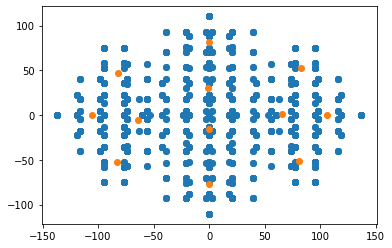

In [48]:
reduced_matrix = pca.transform(matrix)
plt.scatter(reduced_matrix[:,0], reduced_matrix[:,1])
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1])
plt.show()

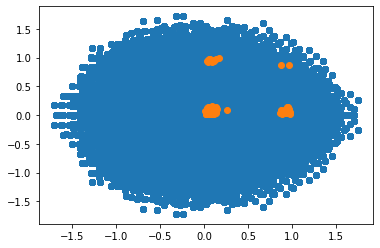

In [103]:
kmeans_bop2 = KMeans(n_clusters=100, random_state=0).fit(np.array(bop))
kmeans_bop2.cluster_centers_

kmeans_bop2.cluster_centers_[0]
pca = PCA(n_components=2)
pca.fit(bop)

reduced_matrix = pca.transform(bop)
plt.scatter(reduced_matrix[:,0], reduced_matrix[:,1])
plt.scatter(kmeans_bop2.cluster_centers_[:,0], kmeans_bop2.cluster_centers_[:,1])
plt.show()

In [39]:
# kmeans = KMeans(n_clusters=12, random_state=0).fit(reduced_matrix)
# kmeans.labels_
# #kmeans.predict([[0, 0], [12, 3]])
# kmeans.cluster_centers_

array([[ 6.40773006e-15, -1.50686765e+01],
       [ 1.05808027e+02,  6.03553529e-12],
       [ 1.29668016e-14,  8.18903996e+01],
       [-6.40766938e+01, -4.97244211e+00],
       [ 8.09729146e+01, -5.17885156e+01],
       [ 3.47731638e-15, -7.73325522e+01],
       [-8.20595883e+01,  4.76041218e+01],
       [ 8.30748160e+01,  5.25864034e+01],
       [-1.18346081e+00,  3.01585291e+01],
       [ 6.60319484e+01,  9.56209316e-01],
       [-1.05808027e+02,  6.09296472e-12],
       [-8.30748160e+01, -5.25864034e+01]])

## SCRATCH

## 3D PCA / K-means

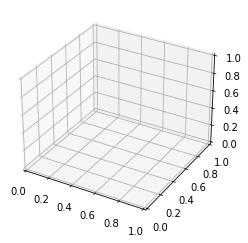

In [59]:
from mpl_toolkits import mplot3d

%matplotlib inline
fig = plt.figure()
ax = plt.axes(projection='3d')

In [31]:
pca3d = PCA(n_components=3)
pca3d.fit(matrix)
reduced_matrix_3d = pca3d.transform(matrix)

kmeans = KMeans(n_clusters=12, random_state=0).fit(reduced_matrix_3d)
kmeans.labels_
#kmeans.predict([[0, 0], [12, 3]])
#kmeans.cluster_centers_

array([ 8,  4,  2, ...,  0, 11,  3], dtype=int32)

In [88]:
kmeans.labels_.shape

(4096,)

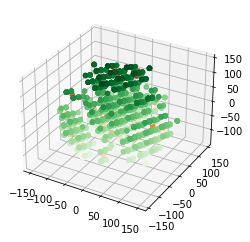

In [86]:
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = reduced_matrix_3d[:,2]
xdata = reduced_matrix_3d[:,0]
ydata = reduced_matrix_3d[:,1]

xcluster = kmeans.cluster_centers_[:,0]
ycluster = kmeans.cluster_centers_[:,1]
zcluster = kmeans.cluster_centers_[:,2]


ax.scatter3D(xcluster, ycluster, zcluster, c=zcluster, cmap='Oranges')
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')



In [75]:
dir(kmeans)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_algorithm',
 '_check_feature_names',
 '_check_mkl_vcomp',
 '_check_n_features',
 '_check_params',
 '_check_test_data',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_init_centroids',
 '_more_tags',
 '_n_init',
 '_n_threads',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_tol',
 '_transform',
 '_validate_center_shape',
 '_validate_data',
 'algorithm',
 'cluster_centers_',
 'copy_x',
 'fit',
 'fit_predict',
 'fit_transform',
 'get_params',
 'inertia_',
 'init',
 'labels_',
 'max_iter',
 'n_clusters',
 'n_features_in_',
 'n_init',
 'n_iter_',
 'predict',
 'random_

https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

first compute distance
second we pass it through pca
then we plot with MDS
then we pick the clustering




1. Compute all policies of length X <--we have this
2. Define similarity metric for paths (policies)
    - Graph edit distance (networkx)
    
    - # of nodes in common
    - # of edges in common
    
    Compute distance for each pair
    
    PCA / tSNE / etc -> plot
    

    Agglomerative clustering
    Aggregated clustering


3. 

In [194]:
G.removed_edges

[(0, 2)]

In [171]:
[edge for edge in list(G_gp.edges())]

[(0, 0), (1, 1), (2, 2)]

In [211]:
actions['change_location']

[((0, 2), (2, 0)),
 ((0, 2), (2, 1)),
 ((0, 2), (2, 2)),
 ((0, 3), (3, 0)),
 ((0, 3), (3, 1)),
 ((0, 3), (3, 3)),
 ((0, 0), (0, 2)),
 ((0, 0), (0, 3)),
 ((0, 0), (0, 0)),
 ((1, 2), (2, 0)),
 ((1, 2), (2, 1)),
 ((1, 2), (2, 2)),
 ((1, 3), (3, 0)),
 ((1, 3), (3, 1)),
 ((1, 3), (3, 3)),
 ((1, 1), (1, 2)),
 ((1, 1), (1, 3)),
 ((1, 1), (1, 1)),
 ((2, 0), (0, 2)),
 ((2, 0), (0, 3)),
 ((2, 0), (0, 0)),
 ((2, 1), (1, 2)),
 ((2, 1), (1, 3)),
 ((2, 1), (1, 1)),
 ((2, 2), (2, 0)),
 ((2, 2), (2, 1)),
 ((2, 2), (2, 2)),
 ((3, 0), (0, 2)),
 ((3, 0), (0, 3)),
 ((3, 0), (0, 0)),
 ((3, 1), (1, 2)),
 ((3, 1), (1, 3)),
 ((3, 1), (1, 1)),
 ((3, 3), (3, 0)),
 ((3, 3), (3, 1)),
 ((3, 3), (3, 3))]

In [729]:
policies = get_policies(num_states, [num_actions], policy_len)

In [731]:
states at t1 = [(1,1), (1, 2), (1,3), (2,1), ...]

remove (1,2)

states at t2 = [(1,1), (1,3), (2,1), ...]

State transition: 
    
    B = (current x previous x action)
    
    previous state distribution * B_matrix = current state distribution
    
    

{'change_location': [((1, 2), (2, 3)),
  ((1, 2), (2, 1)),
  ((1, 2), (2, 2)),
  ((1, 3), (3, 2)),
  ((1, 3), (3, 1)),
  ((1, 3), (3, 3)),
  ((1, 1), (1, 2)),
  ((1, 1), (1, 3)),
  ((1, 1), (1, 1)),
  ((2, 3), (3, 2)),
  ((2, 3), (3, 1)),
  ((2, 3), (3, 3)),
  ((2, 1), (1, 2)),
  ((2, 1), (1, 3)),
  ((2, 1), (1, 1)),
  ((2, 2), (2, 3)),
  ((2, 2), (2, 1)),
  ((2, 2), (2, 2)),
  ((3, 2), (2, 3)),
  ((3, 2), (2, 1)),
  ((3, 2), (2, 2)),
  ((3, 1), (1, 2)),
  ((3, 1), (1, 3)),
  ((3, 1), (1, 1)),
  ((3, 3), (3, 2)),
  ((3, 3), (3, 1)),
  ((3, 3), (3, 3))]}

In [346]:
Ac = Categorical(values=A)
Bc = Categorical(values=B)


In [382]:
initial_states

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [391]:
weights = np.array([obs[1] for obs in observations['pair_plus_edge_weight']])

In [762]:
np_policies[0,1]

array([0])

In [779]:
idx_1 = set(np.where(np_policies[:,0] == [6])[0])
idx_2 = set(np.where(np_policies[:,1] == [0])[0])
the_policies = np_policies[list(idx_1.intersection(idx_2))]
the_indices = list(idx_1.intersection(idx_2))

idx_3 = set(np.where(np_policies[:,0] == [7])[0])
idx_4 = set(np.where(np_policies[:,1] == [5])[0])
more_policies = np_policies[list(idx_3.intersection(idx_4))]
more_indices = list(idx_3.intersection(idx_4))

In [784]:
print("optimal")
for idx in the_indices:
    print("policy", policies[idx], "EFE", EFE[idx])

print("real")
for idx in more_indices:
    print("policy", policies[idx], "EFE", EFE[idx])

optimal
policy [[6]
 [0]
 [0]] EFE [-3.29583693]
policy [[6]
 [0]
 [1]] EFE [-3.29583693]
policy [[6]
 [0]
 [2]] EFE [-3.29583693]
policy [[6]
 [0]
 [3]] EFE [-3.29583693]
policy [[6]
 [0]
 [4]] EFE [-3.29583693]
policy [[6]
 [0]
 [5]] EFE [-3.29583693]
policy [[6]
 [0]
 [6]] EFE [-3.29583693]
policy [[6]
 [0]
 [7]] EFE [-3.29583693]
policy [[6]
 [0]
 [8]] EFE [-3.29583693]
policy [[6]
 [0]
 [9]] EFE [-3.29583693]
policy [[ 6]
 [ 0]
 [10]] EFE [-3.29583693]
policy [[ 6]
 [ 0]
 [11]] EFE [-3.29583693]
policy [[ 6]
 [ 0]
 [12]] EFE [-3.29583693]
policy [[ 6]
 [ 0]
 [13]] EFE [-3.29583693]
policy [[ 6]
 [ 0]
 [14]] EFE [-3.29583693]
policy [[ 6]
 [ 0]
 [15]] EFE [-3.29583693]
policy [[ 6]
 [ 0]
 [16]] EFE [-3.29583693]
policy [[ 6]
 [ 0]
 [17]] EFE [-3.29583693]
policy [[ 6]
 [ 0]
 [18]] EFE [-3.29583693]
policy [[ 6]
 [ 0]
 [19]] EFE [-3.29583693]
policy [[ 6]
 [ 0]
 [20]] EFE [-3.29583693]
policy [[ 6]
 [ 0]
 [21]] EFE [-3.29583693]
policy [[ 6]
 [ 0]
 [22]] EFE [-3.29583693]
policy [[ 

In [752]:
policies.index(np.array([[0],[0],[0]]))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [395]:
edge_penalty = np.dot(weights, initial_states[0])
edge_penalty

5.0

In [448]:
initial_beliefs

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [718]:
states

{'node_pair': [(1, 2),
  (1, 3),
  (1, 1),
  (2, 3),
  (2, 1),
  (2, 2),
  (3, 2),
  (3, 1),
  (3, 3)]}

In [789]:
actions['change_location'][25]

((3, 3), (3, 1))

In [337]:
actions['change_location'][25]

[array([[0],
        [0],
        [0]]),
 array([[0],
        [0],
        [1]]),
 array([[0],
        [0],
        [2]]),
 array([[0],
        [0],
        [3]]),
 array([[0],
        [0],
        [4]]),
 array([[0],
        [0],
        [5]]),
 array([[0],
        [0],
        [6]]),
 array([[0],
        [0],
        [7]]),
 array([[0],
        [0],
        [8]]),
 array([[0],
        [0],
        [9]])]

In [23]:
policies[:1]

[array([[0],
        [0],
        [0]])]

In [366]:
[actions['change_location'][a[0]] for a in policies[0]]

[((1, 2), (2, 3)), ((1, 2), (2, 3)), ((1, 2), (2, 3))]

In [343]:
actions['change_location'][0]

((1, 2), (2, 3))

In [344]:
[a for a in policies[0][0]]

[0]

In [120]:
policy_idx_dict

NameError: name 'policy_idx_dict' is not defined

In [40]:
actions['change_location'][18]

((3, 2), (2, 3))

In [113]:
len(policies)

2187

In [127]:
def expand_policy(actions, policy_idx):
    return [actions['change_location'][policies[policy_idx][0][0]],
            actions['change_location'][policies[policy_idx][1][0]],
            actions['change_location'][policies[policy_idx][2][0]]
            ]

for idx in range(100):
    print(idx)
    print(expand_policy(actions, idx))

0
[((1, 2), (2, 3)), ((3, 2), (2, 3)), ((3, 2), (2, 3))]
1
[((1, 2), (2, 3)), ((3, 2), (2, 3)), ((3, 2), (2, 1))]
2
[((1, 2), (2, 3)), ((3, 2), (2, 3)), ((3, 2), (2, 2))]
3
[((1, 2), (2, 3)), ((3, 2), (2, 3)), ((3, 1), (1, 2))]
4
[((1, 2), (2, 3)), ((3, 2), (2, 3)), ((3, 1), (1, 3))]
5
[((1, 2), (2, 3)), ((3, 2), (2, 3)), ((3, 1), (1, 1))]
6
[((1, 2), (2, 3)), ((3, 2), (2, 3)), ((3, 3), (3, 2))]
7
[((1, 2), (2, 3)), ((3, 2), (2, 3)), ((3, 3), (3, 1))]
8
[((1, 2), (2, 3)), ((3, 2), (2, 3)), ((3, 3), (3, 3))]
9
[((1, 2), (2, 3)), ((3, 2), (2, 1)), ((1, 2), (2, 3))]
10
[((1, 2), (2, 3)), ((3, 2), (2, 1)), ((1, 2), (2, 1))]
11
[((1, 2), (2, 3)), ((3, 2), (2, 1)), ((1, 2), (2, 2))]
12
[((1, 2), (2, 3)), ((3, 2), (2, 1)), ((1, 3), (3, 2))]
13
[((1, 2), (2, 3)), ((3, 2), (2, 1)), ((1, 3), (3, 1))]
14
[((1, 2), (2, 3)), ((3, 2), (2, 1)), ((1, 3), (3, 3))]
15
[((1, 2), (2, 3)), ((3, 2), (2, 1)), ((1, 1), (1, 2))]
16
[((1, 2), (2, 3)), ((3, 2), (2, 1)), ((1, 1), (1, 3))]
17
[((1, 2), (2, 3)), ((

In [ ]:
pol = {(1, 2): [np.array([[0,0,18]]), np.array([[0,0,19]])], (3, 1): [np.array([0,0,18])]}


policies = {(1, 2): [policy_1, policy_2, ...], (2, 3): [policy_1], (3, 2): [policy_1, policy_2, ...]}


all_policies = dict() /\

initial setup:
active_policies = union of values of all_policies

each timestep:
active_policies = active_policies.difference(policies[(removed_edge)]).union(policies[(added_edge)])


In [226]:
for policy_idx in policy_idx_dict[(1,1)]:
    print([actions['change_location'][policies[policy_idx][idx][0]] for idx in range(4)])

[((4, 4), (4, 4)), ((4, 4), (4, 3)), ((4, 3), (3, 1)), ((3, 1), (1, 1))]
[((1, 2), (2, 3)), ((2, 3), (3, 2)), ((3, 2), (2, 1)), ((2, 1), (1, 1))]
[((1, 2), (2, 3)), ((2, 3), (3, 1)), ((3, 1), (1, 1)), ((1, 1), (1, 2))]
[((1, 2), (2, 3)), ((2, 3), (3, 1)), ((3, 1), (1, 1)), ((1, 1), (1, 3))]
[((1, 2), (2, 3)), ((2, 3), (3, 1)), ((3, 1), (1, 1)), ((1, 1), (1, 1))]
[((1, 2), (2, 3)), ((2, 3), (3, 3)), ((3, 3), (3, 1)), ((3, 1), (1, 1))]
[((5, 4), (4, 5)), ((4, 5), (5, 2)), ((5, 2), (2, 1)), ((2, 1), (1, 1))]
[((1, 2), (2, 5)), ((2, 5), (5, 2)), ((5, 2), (2, 1)), ((2, 1), (1, 1))]
[((5, 4), (4, 3)), ((4, 3), (3, 2)), ((3, 2), (2, 1)), ((2, 1), (1, 1))]
[((1, 2), (2, 1)), ((2, 1), (1, 2)), ((1, 2), (2, 1)), ((2, 1), (1, 1))]
[((5, 4), (4, 3)), ((4, 3), (3, 1)), ((3, 1), (1, 1)), ((1, 1), (1, 2))]
[((5, 4), (4, 3)), ((4, 3), (3, 1)), ((3, 1), (1, 1)), ((1, 1), (1, 3))]
[((5, 4), (4, 3)), ((4, 3), (3, 1)), ((3, 1), (1, 1)), ((1, 1), (1, 1))]
[((1, 2), (2, 1)), ((2, 1), (1, 3)), ((1, 3), (3, 1